In [1]:
import numpy as np
import pandas as pd
import janitor

from functools import partial

In [2]:
wt ="MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

In [3]:
def aa_pos(mut):
    """
    Return mutation position from mutation string.

    Example: A111C -> 111
    """
    if not mut:
        return mut
    else:
        return int(mut[2:-1])


def aa_letter(mut):
    """
    Return mutation letter from mutation string.

    Example: A111C -> C
    """
    if not mut:
        return mut
    else:
        return mut[-1]


def mut2seq(mutation_string, wt_sequence, delimiter=":"):
    """
    Reconstruct full mutant sequence given mutation string.

    Example mutation_strings:
    - A111C
    - A111T; V130A
    - A111T; Q194R; N249I; N251Y; H255Y
    """
    if mutation_string is None or mutation_string == "":
        return wt_sequence

    mutations = mutation_string.split(delimiter)
    mutant_sequence = list(wt_sequence)  # mutant_sequence is a list
    for mut in mutations:
        position = aa_pos(mut)
        letter = aa_letter(mut)
        if position == 0:
            raise ValueError(
                f"""
            The mutation string {mut} is invalid.
            It has "0" as its position.
            """
            )
        if position > len(wt_sequence):
            raise ValueError(
                f"""
            The mutation string {mut} is invalid.
            Its position is greater than the length of the WT sequence.
            """
            )
        mutant_sequence[
            position - 1
        ] = letter  # -1 is necessary because the list is zero-indexed
    return "".join(l for l in mutant_sequence)

In [4]:
def count_mutations(x):
    if x == '':
        return 0
    else:
        return len(x.split(":"))


In [5]:
mut2gfp = partial(mut2seq, wt_sequence=wt)

## Prepare data

In [6]:
data = (pd.read_csv("data/amino_acid_genotypes_to_brightness.tsv", sep='\t')
        .fill_empty("aaMutations", "")
        .filter_string("aaMutations", search_string="\*", complement=True)
        .transform_column("aaMutations", mut2gfp, "sequence")
        .transform_column("medianBrightness", lambda x: np.log(x), "log_bright")
        .transform_column("sequence", lambda x: len(x), "length")
        .transform_column("aaMutations", count_mutations, "mutation_count")
       )

/home/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/janitor/functions.py:2246: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dest_column_name] = df[column_name].apply(function)


In [7]:
data.head(3)

,aaMutations,uniqueBarcodes,medianBrightness,std,sequence,log_bright,length,mutation_count
0,,3645,3.719212,0.106992,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.313512,238,0
1,SA108D,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.263156,238,1
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.263157,238,5


In [8]:
data.mutation_count.unique()

array([ 0,  1,  5,  4,  2,  6,  3,  7,  8, 11, 12, 10,  9, 13, 14, 15])

In [9]:
data.length.unique()

array([238])

## Get reps

In [10]:
from jax_unirep import get_reps

In [11]:
h_final, c_final, h_avg = get_reps(data.sequence.values)

/home/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [12]:
h_avg.shape

(51715, 1900)

In [13]:
data["h_avg"] = h_avg.tolist()
data["h_final"] = h_final.tolist()
data["c_final"] = c_final.tolist()

In [14]:
def fusion(x):
    return np.concatenate((x.h_final,x.c_final, x.h_avg))

In [15]:
data = data.join_apply(fusion, "unirep_fusion")

In [16]:
data.head(3)

,aaMutations,uniqueBarcodes,medianBrightness,std,sequence,log_bright,length,mutation_count,h_avg,h_final,c_final,unirep_fusion
0,,3645,3.719212,0.106992,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.313512,238,0,"[0.005286789033561945, -0.047703251242637634, ...","[0.0005321554490365088, 0.0019708347972482443,...","[0.5109664797782898, 0.0102715864777565, 11.35...","[0.0005321554490365088, 0.0019708347972482443,..."
1,SA108D,1,1.301030,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.263156,238,1,"[0.005465304013341665, -0.04703034088015556, 0...","[0.00045735202729701996, 0.03457057476043701, ...","[0.4147320091724396, 0.21859541535377502, 11.3...","[0.00045735202729701996, 0.03457057476043701, ..."
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,0.263157,238,5,"[0.005316670518368483, -0.044092994183301926, ...","[0.0017800081986933947, 0.16200435161590576, 0...","[0.6734200716018677, 0.8357833027839661, 11.74...","[0.0017800081986933947, 0.16200435161590576, 0..."


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
sns.set_style("white")
sns.set_context(context="paper", font_scale=1.5)

In [21]:
df = pd.DataFrame.from_items(zip(data['h_avg'].index, data['h_avg'].values)).T
df['brightness'] = data["medianBrightness"].values
df.set_index(data['aaMutations'], inplace=True)
df.head(3)

/home/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,1891,1892,1893,1894,1895,1896,1897,1898,1899,brightness
aaMutations,,,,,,,,,,,,,,,,,,,,,
,0.005287,-0.047703,0.034449,-0.006703,-0.034524,0.035922,-0.330424,-0.014642,-0.005357,0.065449,...,0.160367,-0.128550,0.049702,-0.130527,0.055046,0.072976,0.029286,0.070990,0.005483,3.719212
SA108D,0.005465,-0.047030,0.035205,-0.008162,-0.062971,0.037026,-0.332218,-0.014865,-0.005466,0.081338,...,0.149888,-0.138496,0.044121,-0.127607,0.058758,0.071847,0.026552,0.072563,0.010115,1.301030
SA108D:SN144D:SI186V:SM231T:SL234P,0.005317,-0.044093,0.033275,-0.007902,-0.066020,0.035382,-0.332055,-0.015488,-0.005496,0.078344,...,0.158680,-0.132788,0.042793,-0.129582,0.051753,0.077186,0.027540,0.074552,0.008035,1.301031


In [22]:
df_bnry = df.copy()
df_bnry["brightness"] = (df["brightness"] < 2.5).astype(int)

In [23]:
X, y = df_bnry.shuffle().get_features_targets(target_column_names=['brightness'])

In [24]:
print(X.shape, y.shape)

(51715, 1900) (51715, 1)


# Training and Testing

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_val_predict, KFold

### Logistic Regression on binary brightness

In [26]:
logreg = LogisticRegression()

In [27]:
# with paLogisticRegressionlel_backend("dask"):
cv = KFold(n_splits=5)
scores = cross_val_score(logreg, X, y.values.ravel(), cv=cv, scoring='accuracy')
preds = cross_val_predict(logreg, X, y.values.ravel(), cv=cv)

/home/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/kummear1/anaconda/envs/genesis/lib/python3.7/site-packages/sklearn/linear_model/lo

In [28]:
scores

array([0.82248864, 0.82374553, 0.82045828, 0.82181185, 0.81591414])

In [29]:
scores.mean()

0.8208836894518031

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
labels = [0, 1]
cm = confusion_matrix(y, preds, labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [41]:
cm

array([[0.92598132, 0.07401868],
       [0.32531903, 0.67468097]])

In [32]:
classes = ["Dark", "Bright"]

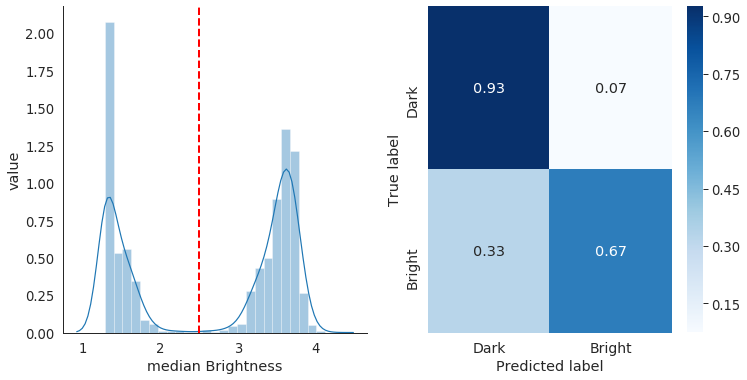

In [47]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

sns.distplot(data["medianBrightness"], ax=ax1)
ax1.axvline(x=2.5, c="r", ls="--", lw=2)
ax1.set(xlabel="median Brightness", ylabel="value")
sns.despine()

df_cm = pd.DataFrame(
    cm, index=classes, columns=classes, 
)

heatmap = sns.heatmap(df_cm, 
                      annot=True, 
                      fmt=".2f", 
                      cmap="Blues",
                      ax=ax2
                     )

ax2.set_yticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, fontsize=14)
ax2.set_xticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, fontsize=14)
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
plt.savefig("figures/top_model.png", bbox_inches='tight', dpi=200)